# Setup

In [5]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate, savefig

# Set the random seed so the notebook
# produces the same results every time.
np.random.seed(17)

In [7]:
# make a directory for figures
!mkdir -p figs

In [8]:
# node colors for drawing networks
colors = sns.color_palette('pastel', 5)
#sns.palplot(colors)
sns.set_palette(colors)

# Create a WS graph

## 1. Create a regular lattice

A ring lattice is a kind of regular graph, which Watts and Strogatz use as the basis of their model.

In a ring lattice with `n` nodes, the nodes can be arranged in a circle with each node connected to the `k` nearest neighbors.

In [ ]:
def adjacent_edges(nodes, halfk):
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            print("i, j:", i , j)
            v = nodes[j % n]
            print('v:', v)
            yield u, v
            print('----------')

For example, a ring lattice with `n = 3` and `k = 2` would contain the following edges: `(0, 1), (1, 2), (2, 0)`.

In [ ]:
nodes = range(3)

for edge in adjacent_edges(nodes, 1):
    print(edge)

i, j: 0 1
v: 1
(0, 1)
----------
i, j: 1 2
v: 2
(1, 2)
----------
i, j: 2 3
v: 0
(2, 0)
----------


The Python modulo operation is used to get the remainder of a division

In [ ]:
1%3

1

In [ ]:
def adjacent_edges(nodes, halfk):
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v


def make_ring_lattice(n, k):
    """
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2)) # assume k is even in this example
    return G

And we can test it out with `n=10` and `k=4`

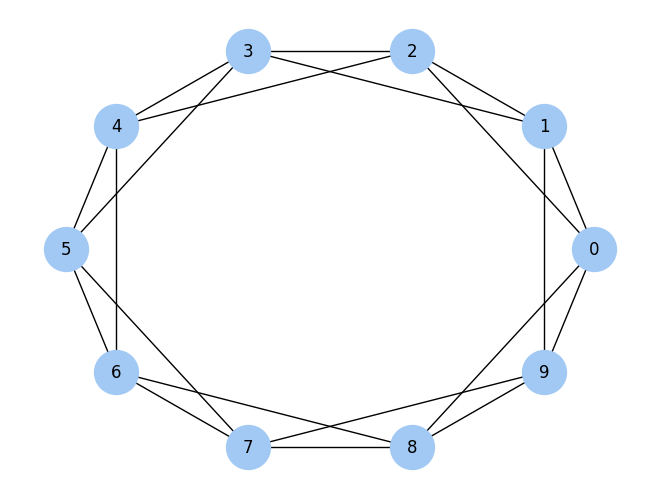

In [ ]:
lattice = make_ring_lattice(10, 4)

nx.draw_circular(lattice,
                 node_color='C0',
                 node_size=1000,
                 with_labels=True)

In [ ]:
len(lattice.edges)

20

## 2. Rewire edges with probability p.

Watts and Strogatz consider the edges in a particular order and rewire each one with probability p.

If an edge is rewired, they leave the first node unchanged and choose the second node at random. They don’t allow self loops or multiple edges;

In [ ]:
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p


def rewire(G, p):
    """Rewires each edge with probability `p`.

    G: Graph
    p: float
    """
    nodes = set(G)
    for u, v in G.edges():
        if flip(p):
            choices = nodes - {u} - set(G[u]) # self loops or multiple edges
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)


def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.

    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

Here's an example with `p=0.2`

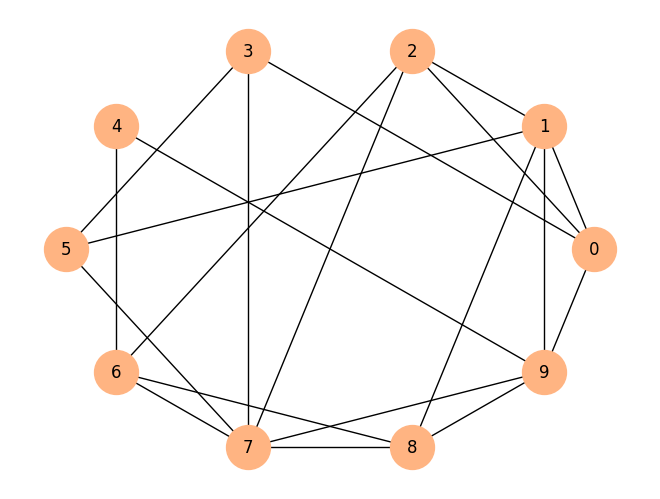

In [ ]:
np.random.seed(17)

ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws,
                 node_color='C1',
                 node_size=1000,
                 with_labels=True)

## 3. WS graphs with different p

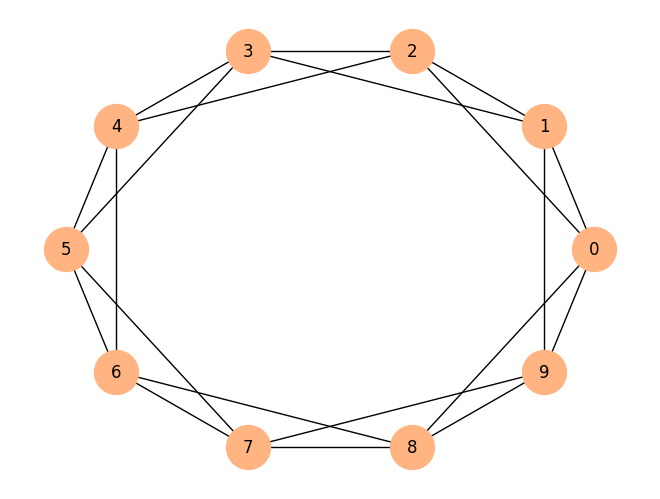

In [ ]:
ws = make_ws_graph(10, 4, 0)
nx.draw_circular(ws,
                 node_color='C1',
                 node_size=1000,
                 with_labels=True)

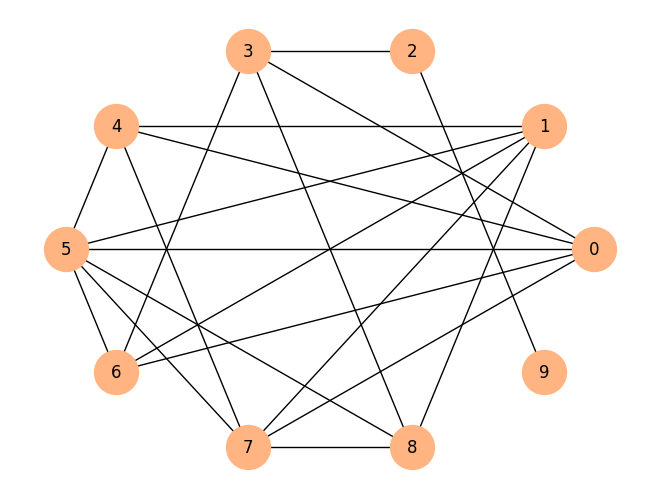

In [ ]:
ws = make_ws_graph(10, 4, 1)
nx.draw_circular(ws,
                 node_color='C1',
                 node_size=1000,
                 with_labels=True)

# Quantify the properties of WS graphs



*   clustering coefficient
*   path length



## Clustering coefficient

The following function computes the local clustering coefficient for a given node, `u`:

In [ ]:
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.

    G: Graph
    u: node

    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan

    possible = k * (k-1) / 2 # if all the neighbors are connected.
    exist = 0
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / possible


# We have seen this function from Week 2 when we tried to make the complete graph
def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v


# The network average clustering coefficient is just the mean of the local clustering coefficient.
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    G: Graph
    returns: float
    """
    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

For example, in a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [ ]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

In this example (regular lattice), the local clustering coefficient for all nodes is 0.5, so the average across nodes is 0.5.

In [ ]:
clustering_coefficient(lattice)

0.5

## Path length

Path length is the average length of the shortest path between each pair of nodes.

`nx.shortest_path_length`: [documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path_length.html)

In [ ]:
def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v


# get the shortest path length between all pairs.
def path_lengths(G):
    length_iter = nx.shortest_path_length(G)
    for source, dist_map in length_iter:
        for dest, dist in dist_map.items():
            if source != dest:
                yield dist


# The characteristic path length is the mean path length for all pairs.
def characteristic_path_length(G):
    return np.mean(list(path_lengths(G)))

In [ ]:
lattice = make_ring_lattice(10, 4)
characteristic_path_length(lattice)

1.6666666666666667

## WS Experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):

In [ ]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.

    n: number of nodes
    k: degree of each node
    p: probability of rewiring

    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

Now we'll run it with a range of values for `p`.

In [ ]:
ps = np.logspace(-4, 0, 9)
print(ps)

[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00]


This function runs each value of `p` several times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.

In [ ]:
def run_experiment(ps, n=1000, k=10, iters=10):
    """Computes stats for WS graphs with a range of `p`.

    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`

    returns:
    """
    res = []
    for p in ps:
        print(p)
        t = [run_one_graph(n, k, p) for _ in range(iters)]
        means = np.array(t).mean(axis=0)
        print(means)
        res.append(means)
    return np.array(res)

In [ ]:
%time res = run_experiment(ps)

0.0001
30.909605605605606 0.6659631313131312
50.450450450450454 0.6666666666666665
50.450450450450454 0.6666666666666665
50.450450450450454 0.6666666666666665
42.189951951951954 0.6661343434343432
50.450450450450454 0.6666666666666665
46.87471871871872 0.66635101010101
50.450450450450454 0.6666666666666665
50.305951951951954 0.6664232323232322
39.93461061061061 0.6662065656565656
[46.24670911  0.66644116]
0.00031622776601683794
32.328648648648645 0.6652808080808079
31.127005005005007 0.6659671717171716
35.22203203203203 0.6660353535353535
34.726536536536535 0.6661075757575756
40.675571571571574 0.6661343434343433
28.44647847847848 0.6648262626262625
32.61093293293293 0.665430808080808
26.035885885885886 0.6652595959595958
44.77702102102102 0.66575
50.450450450450454 0.6666666666666665
[35.64005626  0.66574586]
0.001
27.707993993993995 0.6655030303030303
25.141307307307308 0.6641949494949495
23.188314314314315 0.6643126262626263
27.0364984984985 0.6654762626262625
27.63634034034034 0.66

In [ ]:
res

array([[4.62467091e+01, 6.66441162e-01],
       [3.56400563e+01, 6.65745859e-01],
       [2.50997083e+01, 6.64586364e-01],
       [1.51954941e+01, 6.60328694e-01],
       [8.81354955e+00, 6.47000397e-01],
       [6.03757037e+00, 6.09705820e-01],
       [4.42375516e+00, 4.88916542e-01],
       [3.57694214e+00, 2.17677375e-01],
       [3.26771211e+00, 9.16674773e-03]])

In [ ]:
L, C = np.transpose(res)

In [ ]:
L

array([46.24670911, 35.64005626, 25.09970831, 15.19549409,  8.81354955,
        6.03757037,  4.42375516,  3.57694214,  3.26771211])

In [ ]:
C

array([0.66644116, 0.66574586, 0.66458636, 0.66032869, 0.6470004 ,
       0.60970582, 0.48891654, 0.21767737, 0.00916675])

In [ ]:
L /= L[0]
C /= C[0]

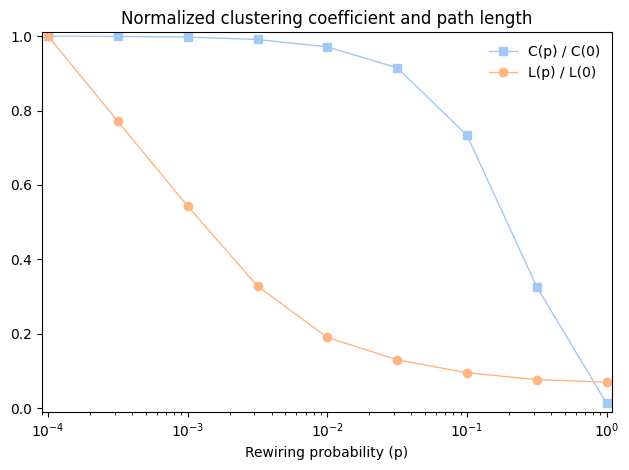

In [ ]:
plt.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
plt.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
decorate(xlabel='Rewiring probability (p)', xscale='log',
         title='Normalized clustering coefficient and path length',
         xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])


# Real data of social networks
Facebook data: https://snap.stanford.edu/data/egonets-Facebook.html

## Download data

In [16]:
download('https://snap.stanford.edu/data/facebook_combined.txt.gz')

Downloaded facebook_combined.txt.gz


Downloaded file can be found in the folder
(Note: this is saved temporarily in colab folder)

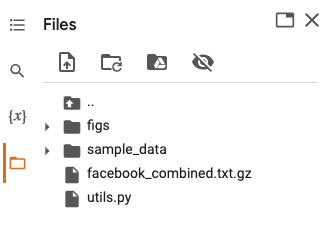

## Load data

In [17]:
# The following function reads a file with one edge per line, specified by two integer node IDs.

def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G


fb = read_graph('facebook_combined.txt.gz')
n = len(fb)
m = len(fb.edges())
n, m

(4039, 88234)

## Average clustering coefficient and estimated path length

With larger graphs, it takes too long to compute clustering coefficients and path lengths, but ***we can estimate them by sampling***.  NetworkX provides a function in its approximation module that estimates the clustering coefficient:

In [18]:
from networkx.algorithms.approximation import average_clustering


# Estimate path length
def sample_path_lengths(G, nodes=None, trials=1000):
    """Choose random pairs of nodes and compute the path length between them.

    G: Graph
    nodes: list of nodes to choose from
    trials: number of pairs to choose

    returns: list of path lengths
    """
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)

    pairs = np.random.choice(nodes, (trials, 2)) # sample 1000 pairs of nodes
    lengths = [nx.shortest_path_length(G, *pair)
               for pair in pairs]
    return lengths


def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(sample_path_lengths(G, nodes, trials))

Average clustering coefficient:

In [19]:
C = average_clustering(fb)
C

0.624

Estimated path length is low:

In [20]:
L = estimate_path_length(fb)
L

3.717

## WS Graph on facebook nodes

Construct a WS graph with the same number of nodes and average degree as the Facebook network:

Average degree is the sum of degree divided by the number of nodes.

When count the sum of degree (of all nodes), an edge will be counted twice.

so `k` would roughly be the twice of averge number of edges per node, `2*m/n`

In [21]:
n = len(fb)
m = len(fb.edges())
k = int(round(2*m/n))
k

44

By trial and error, `p=0.05` yields a graph with about the right values for `C` and `L` of facebook data.

[`nx.watts_strogatz_graph` documentation](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html)

In [22]:
# n: number of nodes
# k: Each node is joined with its k nearest neighbors in a ring topology.


import networkx as nx

ws = nx.watts_strogatz_graph(n, k, 0.05, seed=15)

In [23]:
# compare C of facebook data, and C of WS graph with p=0.05

C, average_clustering(ws)

(0.624, 0.618)

In [24]:
# compare estimated L of facebook data, and estimated L of WS graph with p=0.05

L, estimate_path_length(ws)

(3.717, 3.236)

## Degree distribution

The following function returns a list of degrees, one for each node:

In [25]:
def degrees(G):
    """List of degrees for nodes in `G`.

    G: Graph object

    returns: list of int
    """
    return [G.degree(u) for u in G]

If we compare the average degree between original facebook data and WS graph, it seems about right.

In [26]:
np.mean(degrees(fb)), np.mean(degrees(ws))

(43.69101262688784, 44.0)

But the standard deviation isn't even close:

In [27]:
np.std(degrees(fb)), np.std(degrees(ws))

(52.41411556737521, 1.4309215628189869)

To better check the distribution, we use **PMF (probability mass function)**

A `Pmf` object maps from each degree to the fraction of nodes with that degree.

In [28]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.7.2-py3-none-any.whl size=12206 sha256=f3f24bcf031edff4ad55ce136f1035764b5044d9c1de56933b7a7986d19ebf8a
  Stored in directory: /root/.cache/pip/wheels/e9/57/8a/15b864f4d5dc20cef626e3a015fec88b19df385ef30a8364cc
Successfully built empiricaldist


In [29]:
from empiricaldist import Pmf

pmf_fb = Pmf.from_seq(degrees(fb))
print(pmf_fb.mean(), pmf_fb.std())

pmf_ws = Pmf.from_seq(degrees(ws))
print(pmf_ws.mean(), pmf_ws.std())

43.69101262688785 52.41411556737521
44.00000000000001 1.4309215628189869


Visualization of PMF

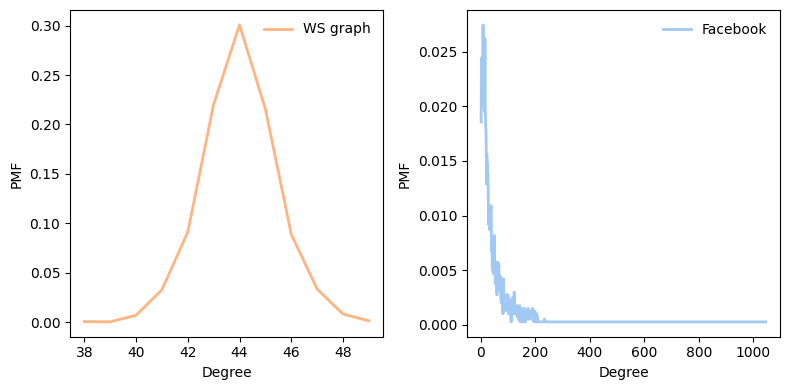

In [30]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,2)
pmf_fb.plot(label='Facebook', color='C0')
decorate(xlabel='Degree', ylabel='PMF')

plt.subplot(1,2,1)
pmf_ws.plot(label='WS graph', color='C1')
decorate(xlabel='Degree', ylabel='PMF')

We can get a better view of the Facebook data by **plotting the PMF on a log-log scale.**

***The result suggests that the degree distribution follows a power law, at least for values larger than 10 or so.***

The log-log scale doesn't help the WS graph.

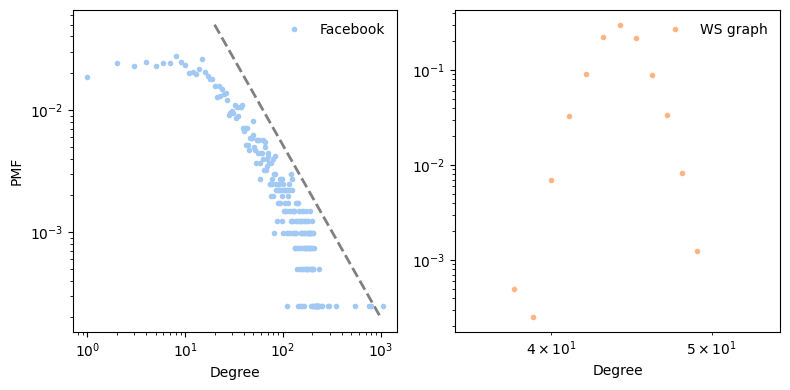

In [31]:
plt.figure(figsize=(8,4))
options = dict(ls='', marker='.')

plt.subplot(1,2,1)
plt.plot([20, 1000], [5e-2, 2e-4], color='gray', linestyle='dashed')

pmf_fb.plot(label='Facebook', color='C0', **options)
decorate(xscale='log', yscale='log',
         xlabel='Degree', ylabel='PMF')

plt.subplot(1,2,2)
pmf_ws.plot(label='WS graph', color='C1', **options)
decorate(xlim=[35, 55],
         xscale='log', yscale='log',
         xlabel='Degree')


## BA model

[`nx.barabasi_albert_graph` Documentation](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html)

Returns a random graph using Barabási–Albert preferential attachment.

A graph of `n` nodes is grown by attaching new nodes each with `m` edges that are preferentially attached to existing nodes with high degree.

In [44]:
ba = nx.barabasi_albert_graph(n=4039, m=22, seed=15)

So the mean degree is about right.

In [45]:
np.mean(degrees(fb)), np.mean(degrees(ba))

(43.69101262688784, 43.76033671700916)

The standard deviation of degree is pretty close, and much better than the WS model.

In [46]:
np.std(degrees(fb)), np.std(degrees(ba))

(52.41411556737521, 40.76091683413431)

Let's take a look at the degree distribution.

In [47]:
pmf_ba = Pmf.from_seq(degrees(ba))

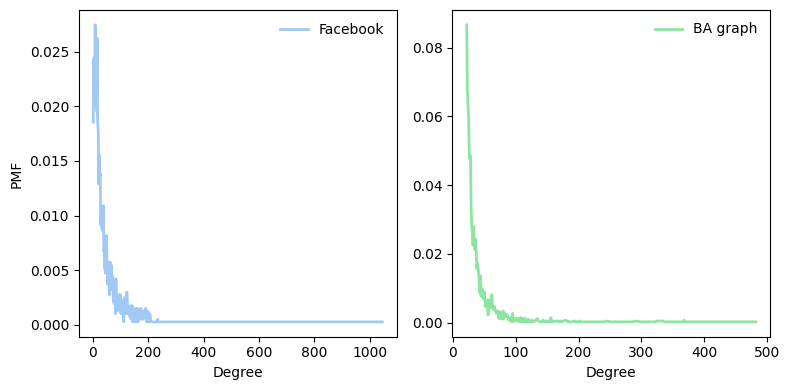

In [48]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
pmf_fb.plot(label='Facebook', color='C0')
decorate(xlabel='Degree', ylabel='PMF')

plt.subplot(1,2,2)
pmf_ba.plot(label='BA graph', color='C2')
decorate(xlabel='Degree')

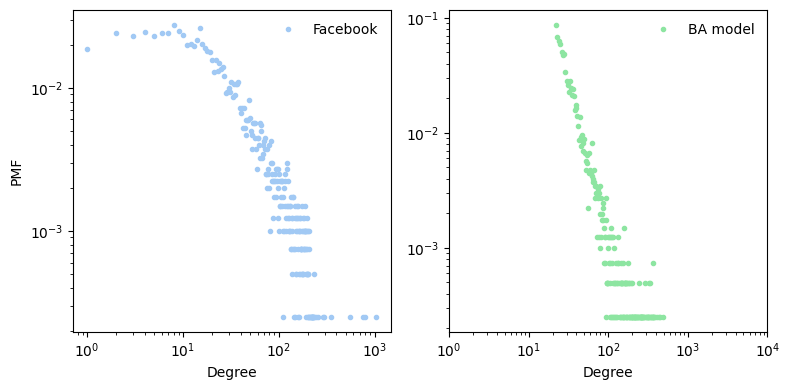

In [49]:
plt.figure(figsize=(8,4))
options = dict(ls='', marker='.')

plt.subplot(1,2,1)

pmf_fb.plot(label='Facebook', color='C0', **options)
decorate(xlabel='Degree', ylabel='PMF',
         xscale='log', yscale='log')

plt.subplot(1,2,2)

pmf_ba.plot(label='BA model', color='C2', **options)
decorate(xlabel='Degree',
         xlim=[1, 1e4],
         xscale='log', yscale='log')

Check the clustering coefficient and path length

In [50]:
L, estimate_path_length(ba)

(3.717, 2.509)

In [51]:
C, average_clustering(ba)

(0.624, 0.039)

In the BA model, the degree distribution is better than in the WS model, but the clustering coefficient is too low.

# Exercises

**Exercise 1**

In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.


In [ ]:
# Solution goes here



**Exercise 2**

NetworkX provides a function called powerlaw_cluster_graph that implements the "Holme and Kim algorithm for growing graphs with powerlaw degree distribution and approximate average clustering". Read the [documentation](https://https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.powerlaw_cluster_graph.html#networkx.generators.random_graphs.powerlaw_cluster_graph) of this function and see if you can use it to generate a graph that has the same number of nodes as the Facebook network, the same average degree, and the same clustering coefficient. How does the degree distribution in the model compare to the actual distribution?

In [ ]:
# Solution goes here




## Solutions

**Exercise 1 Solution**

In [9]:
# Solution

# Here's `adjacent_edges`:

def adjacent_edges(nodes, halfk):
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v


# And here's a function that computes edges that connect each
# node to the one half-way around the circle

def opposite_edges(nodes):
    """Enumerates edges that connect opposite nodes."""
    n = len(nodes)
    for i, u in enumerate(nodes):
        j = i + n//2
        v = nodes[j % n]
        yield u, v


# Now we can make regular graphs.

def make_regular_graph(n, k):
    """Makes graph with `n` nodes where all nodes have `k` neighbors.

    Not possible if both `n` and `k` are odd.
    """
    # a is the number of adjacent edges
    # b is the number of opposite edges (0 or 1)
    # divmod() takes two numbers and returns a pair of numbers consisting of their quotient and remainder.
    a, b = divmod(k, 2)

    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, a))

    # if k is odd, add opposite edges
    if b: # if b!=0
        if n%2: # if n is odd
            msg = "Can't make a regular graph if n and k are odd."
            raise ValueError(msg)
        G.add_edges_from(opposite_edges(nodes))
    return G


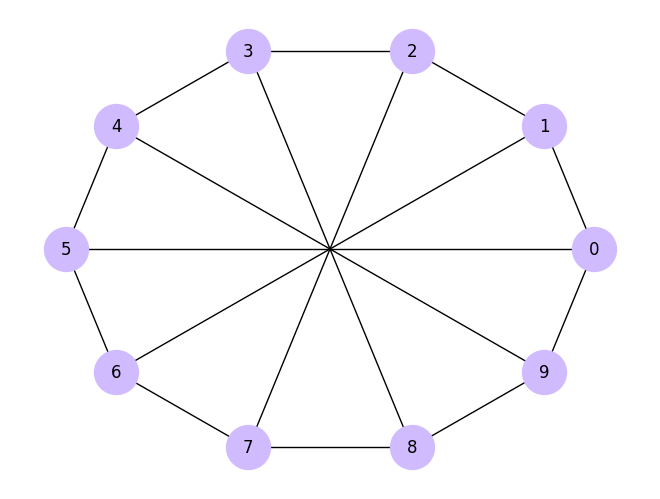

In [14]:
# Here's an example.

regular = make_regular_graph(10, 3)

nx.draw_circular(regular,
                 node_color='C4',
                 node_size=1000,
                 with_labels=True)

**Exercise 2 Solution**

In [33]:
# Here are the parameters of the Facebook data

n = len(fb)
m = len(fb.edges())
k = int(round(m / n))
n, m, k

(4039, 88234, 22)

In [34]:
# Solution

# Now we can make an HK graph with these parameters,
# and with the target clustering as high as possible.

hk = nx.powerlaw_cluster_graph(n, k, 1.0, seed=15)
len(hk), len(hk.edges())

(4039, 88363)

In [35]:
# The average clustering is much higher than in the BA
# model, but still not as high as in the data.

C, average_clustering(hk)

(0.624, 0.288)

In [36]:
# The average path length is even lower than in the data.

L, estimate_path_length(hk)

(3.717, 2.774)

In [37]:
# The mean degree is about right.

np.mean(degrees(fb)), np.mean(degrees(hk))

(43.69101262688784, 43.75488982421391)

In [38]:
# The standard deviation of degree is a little low

np.std(degrees(fb)), np.std(degrees(hk))

(52.41411556737521, 43.106377456263075)

In [39]:
from empiricaldist import Pmf

pmf_hk = Pmf.from_seq(degrees(hk))
print(pmf_hk.mean(), pmf_hk.std())

43.75488982421391 43.10637745626307


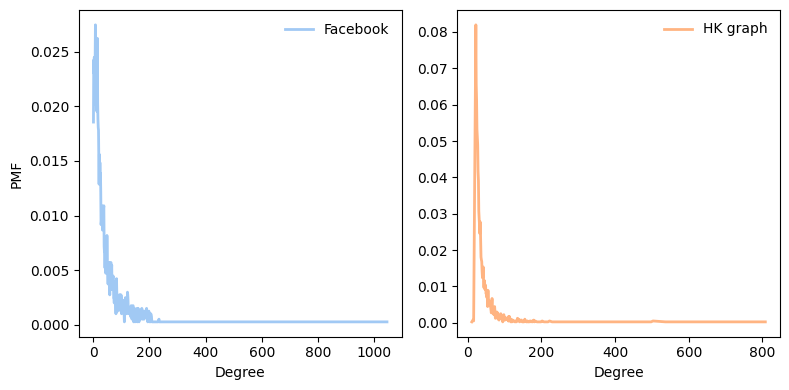

In [40]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
pmf_fb.plot(label='Facebook', color='C0')
decorate(xlabel='Degree', ylabel='PMF')

plt.subplot(1,2,2)
pmf_hk.plot(label='HK graph', color='C1')
decorate(xlabel='Degree')

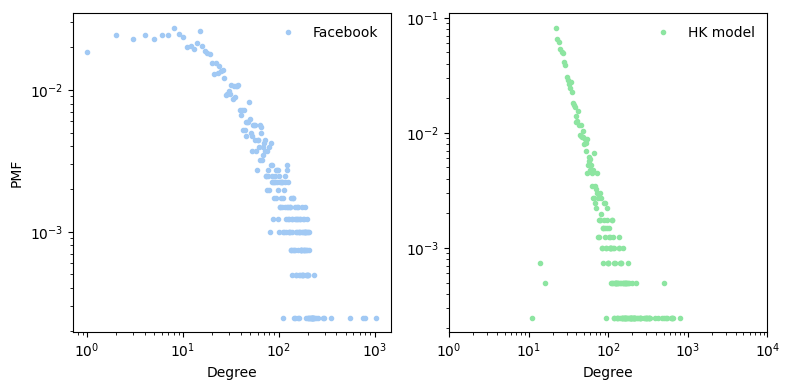

In [60]:
# on a log-log axis

plt.figure(figsize=(8,4))
options = dict(ls='', marker='.')

plt.subplot(1,2,1)

pmf_fb.plot(label='Facebook', color='C0', **options)
decorate(xlabel='Degree', ylabel='PMF',
         xscale='log', yscale='log')

plt.subplot(1,2,2)

pmf_hk.plot(label='HK model', color='C2', **options)
decorate(xlabel='Degree',
         xlim=[1, 1e4],
         xscale='log', yscale='log')
